<img src="https://www.unizar.es/sites/default/files/identidadCorporativa/imagen/logoUZ.png"  width="480">

# UNSUPERVISED MUSIC STRUCTURE ANNOTATION BY TIME SERIES STRUCTURE FEATURES AND SEGMENT SIMILARITY

Coded by: Carlos Hernández, José Ramón Beltrán, David Díaz-Guerra

Department of Electronic Engineering and Communications, Universidad de Zaragoza, Calle María de Luna 3, 50018 Zaragoza


This notebook provides step by step the calculation of te Recurrence Plot, Lag time matrix, Structure Features and Novelty Curve  according to the IEEE 2014 paper: "Unsupervised Music Structure Annotation by Time
Series Structure Features and Segment Similarity." of J. Serrà, M. Müler, P. Grosche and J. Ll. Arcos.
https://ieeexplore.ieee.org/document/6763101
            
Abbreviations: 
* HPCPs: Chromas considering harmonic frequencies = $X$: Time series
* $R$: Recurrence plot
* $L$: Lag Time matrix
* $P$: Structure Features
* $c$: Novelty curve
* $S_{u,u}$: Segment Similarity matrix
* $\hat{S}$: Transitive binary similarity matrix

The first step is to import all the libraries that we need to run our code:

In [1]:
import librosa
import librosa.display
import librosa.segment
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
import math
from scipy import signal

We import the song we want to process

In [2]:
song = "6"
song_path = "/home/carlos/Documentos/" + song + ".mp3"

Now we set the parameter's values

In [3]:
#------------PARAMETERS--------------
window_size = 0.209 #sec/frame
samples_frame = 8192 #samples_frame = math.ceil(window_size*sr) 
hop_size = 0.139 #sec/frame
hop_length = 6144 #hop_length = math.ceil(hop_size*sr) #overlap 25% (samples/frame)
sr_desired = 44100 

We need to be sure that the sampling frequency is set to 44100Hz, otherwise we resample the signal

In [4]:
y, sr = librosa.load(song_path, sr=None)

if sr != sr_desired:
    y = librosa.core.resample(y, sr, sr_desired)
    sr = sr_desired

/home/carlos/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


## A. Music Descriptor Time Series

### Short-Time Fourier Transform

We convert sthe signal ($y$) in a time series of length $N'$ (chromas).
To do that, we first compute the Short-Time Fourier Transform:

In [5]:
#------------Fourier Fast Transform-------------
stft = np.abs(librosa.stft(y, n_fft=samples_frame, hop_length=hop_length))
fft_freq = librosa.core.fft_frequencies(sr=sr, n_fft=samples_frame)

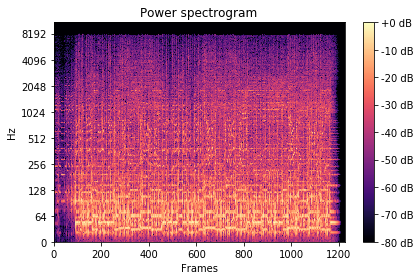

In [6]:
"""-----------PLOTTING MEL-SPECTROGRAM-------------"""
#Spectogram from SFTF
librosa.display.specshow(librosa.amplitude_to_db(stft,ref=np.max),y_axis='log', x_axis='frames')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

### Chroma Features or PCPs

We compute the chromas which will be the time series of length $N'$ described in Serrà's et al. paper:

\begin{equation}
\mathrm{chromas = X} = [\mathrm{x}_1,...,\mathrm{x}_{N'}]
\end{equation}

where each $\mathrm{x}_i$ is a column vector of the chroma's matrix.

In [7]:
#------------PCP calculation (Chroma)-------------
chroma = librosa.feature.chroma_stft(S=stft, sr=sr, n_fft=samples_frame, hop_length=hop_length)

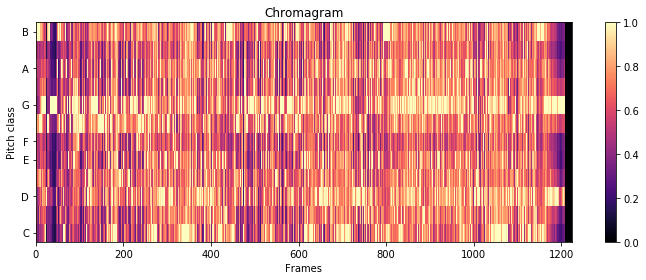

Chroma dimensions are: [chroma vectors, N']
Chroma dimensions are: [ 12 , 1224 ]


In [8]:
"""-----------PLOTTING CHROMAS-------------"""
#PCPs or Chroma from spectogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, sr=sr, y_axis='chroma', x_axis='frames')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()
plt.show()
print("Chroma dimensions are: [chroma vectors, N']")
print("Chroma dimensions are: [", chroma.shape[0], ",", chroma.shape[1],"]")

## B. Segment Boundaries

We construct new samples by concatenating the chromas with themselves after applying a time delay $\tau$ and embeeding them.

\begin{equation}
\mathrm{\hat{x}}_i = [\mathrm{x}_i^\mathrm{T} \mathrm{x}_{i-\tau}^\mathrm{T}...\mathrm{x}_{i-(m-1)\tau}^\mathrm{T}]
\end{equation}

Parameters: 
* Embedding dimension: m = 5 seconds = 5 * 44100 / 6144 = 36 samples
* Time delay: $\tau$ = 1 sample

In [9]:
#vector x_hat construction. x in Serra's paper is chroma here
m = round(5*sr/hop_length)
tau = 1
w = (m-1)*tau
chroma = np.concatenate((np.zeros((chroma.shape[0], w)), chroma), axis=1)
x = [np.roll(chroma,tau*n,axis=1) for n in range(m)]
x_ = np.concatenate(x, axis=0)

X_gorro = x_[:,w:] #(w, frames)

N_prima = chroma.shape[1]
N = N_prima - w

We can plot $\mathrm{\hat{x}}_i$ to better understand this concatenation:

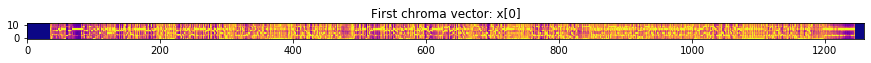

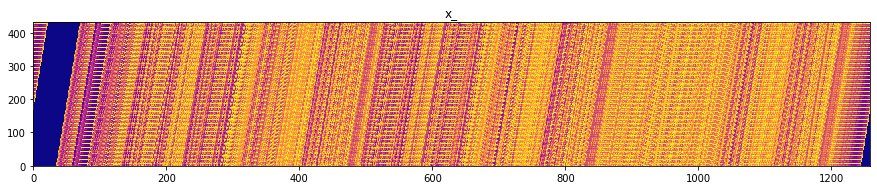

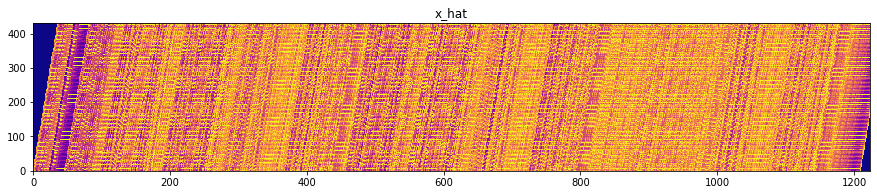

X_gorro dimensions are: [chroma vectors * m (in samples), N'] = [ 12 * 36 , N']
X_gorro dimensions are: [ 432 , 1224 ]


In [46]:
"""PLOTTING x, x_ and the resulting x_hat"""
#x (first chroma)
plt.figure(figsize=(15, 7))
plt.title('First chroma vector: x[0]')
plt.imshow(np.asarray(x[0]), origin='lower', cmap='plasma', aspect=2)
plt.show()

#x_
plt.figure(figsize=(15, 7))
plt.title('x_')
plt.imshow(x_, origin='lower', cmap='plasma', aspect=0.5)
plt.show()

#x_hat
plt.figure(figsize=(15, 7))
plt.title('x_hat')
plt.imshow(X_gorro, origin='lower', cmap='plasma', aspect=0.5)
plt.show()
print("X_gorro dimensions are: [chroma vectors * m (in samples), N'] = [",chroma.shape[0],"*",m,", N']")
print("X_gorro dimensions are: [", X_gorro.shape[0], ",", X_gorro.shape[1],"]")

We can also plot the SSM and SSM with k neighbors using directly Librosa library:

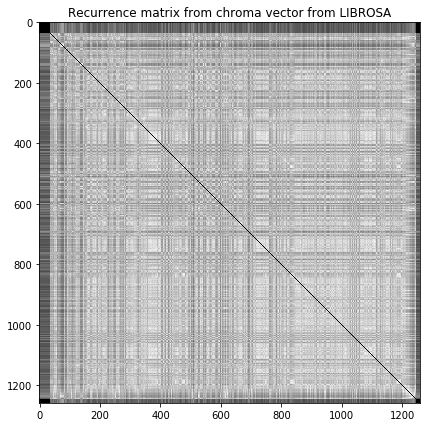

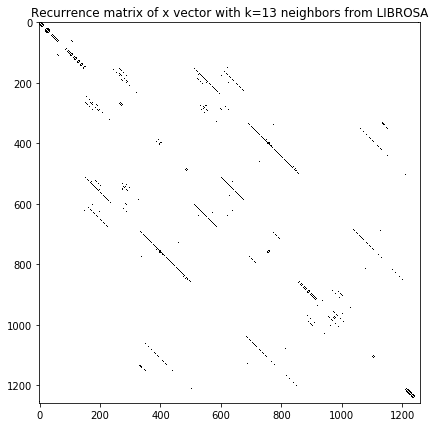

In [11]:
"""PLOTTING RECURRENCE PLOT with Librosa from CHROMAS"""
#Recurrence matrix from librosa
recurrence = librosa.segment.recurrence_matrix(chroma, mode='affinity', k=chroma.shape[1])
plt.figure(figsize=(7, 7))
plt.title('Recurrence matrix from chroma vector from LIBROSA')
plt.imshow(recurrence, cmap='gray')
plt.show()

#Plot recurrence matrix of vector x with librosa
recurrence2 = librosa.segment.recurrence_matrix(x, k=14, sym='True')
plt.figure(figsize=(7, 7))
plt.title('Recurrence matrix of x vector with k=13 neighbors from LIBROSA')
plt.imshow(1-recurrence2, cmap='gray')
plt.show()

Followinf Serrà's et al. paper, we calculate the Recurrence plot (or SSM matrix) usinf the $k-nn$ algorithm with k = 13 neighbors:

In [12]:
#------------K-Nearest-Neighboors-------------
K = 14 #K = round(N*0.03)
nbrs = NearestNeighbors(n_neighbors=K).fit(X_gorro.T)
distances, indices = nbrs.kneighbors(X_gorro.T)
R = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if (i in indices[j]) and (j in indices[i]) and (i != j):
            R[i,j] = 1

If we plot the Recurrence plot obtained we get the matrix below which we can compare with the matrix obtained with Librosa library above:

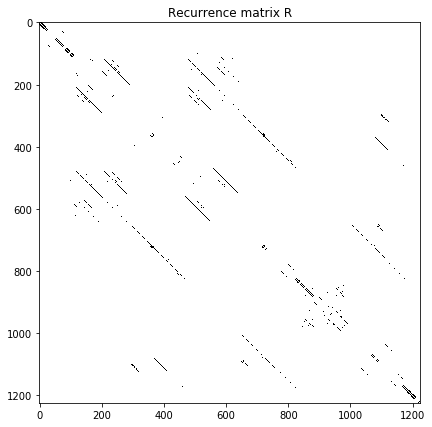

In [13]:
"""PLOTTING RECURRENCE PLOT"""
#Plot recurrence matrix of vector R (same as above)
plt.figure(figsize=(7, 7))
plt.title('Recurrence matrix R')
plt.imshow(1-R, cmap='gray')
plt.show()

Now we convert the Recurrence plot or SSM in a SSLM with Librosa library following the equation:

\begin{equation}
L_{i,j} = R_{k+1,j}
\end{equation}

where $k = i + j - 2 \mathrm{module} N$

In [14]:
#------------Lag matrix construction-------------
L = librosa.segment.recurrence_to_lag(R, pad=None)

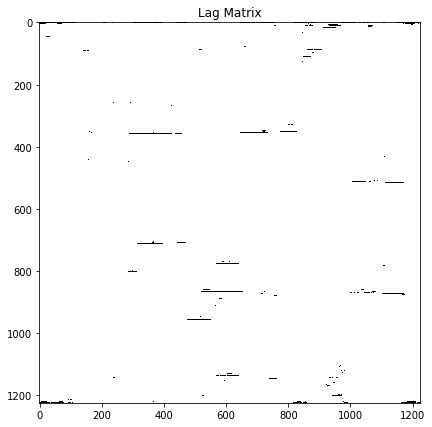

In [15]:
"""PLOTTING LAG MATRIX"""
#Lag Matrix calculated from R
plt.figure(figsize=(7, 7))
plt.title('Lag Matrix')
plt.imshow(1-L, cmap='gray')
plt.show()

We now construct the kernel $G$. This kernel is composed by two gaussian windows $\mathrm{g}_1$ and $\mathrm{g}_t$ with sizes $\mathrm{s}_1$ = 0.3 and $\mathrm{s}_t$ = 30 seconds respectively.

$G$ will have $\mathrm{s}_1$ rows and $\mathrm{s}_t$ columns.

In [16]:
#Smoothing signal with Gaussian windows of 30 samples length
s1 = round(0.3*sr/hop_length)
st = round(30*sr/hop_length)
sigma1 = (s1 -1)/(2.5*2)
sigmat = (st -1)/(2.5*2)
g1 = signal.gaussian(s1, std=sigma1).reshape(s1,1) #g1 in paper
gt = signal.gaussian(st, std=sigmat).reshape(st,1) #gt in paper
G = np.matmul(g1,gt.T)

We can plot the gaussian window $\mathrm{g}_t$ and the resulting gaussian kernel $G$:

Text(0.5, 0, 'Sample')

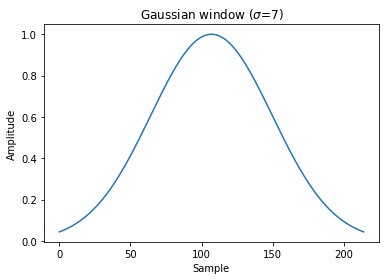

In [17]:
"""PLOTTING GAUSSIAN WINDOW"""
#Plot Gaussian window
plt.plot(gt)
plt.title("Gaussian window ($\sigma$=7)")
plt.ylabel("Amplitude")
plt.xlabel("Sample")

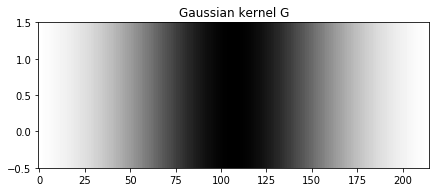

In [18]:
"""PLOTTING G"""
#Gaussian kernel G
plt.figure(figsize=(7, 7))
plt.title('Gaussian kernel G')
plt.imshow(1-G, origin='lower', cmap='gray', aspect=40)
plt.show()

After obtaining the gaussian kernel G, we convolve matrix L with kernel G:

\begin{equation}
P = L * G
\end{equation}

In [19]:
#Applyin gaussian filter to Lag matrix
P = signal.convolve2d(L, G, mode='same')

After computing $P$, we can show the Recurrence plot after convolving it with the kernel $G$, and the $P$ matrix which is the Lag matrix $L$ after convolving it with $G$ kernel:

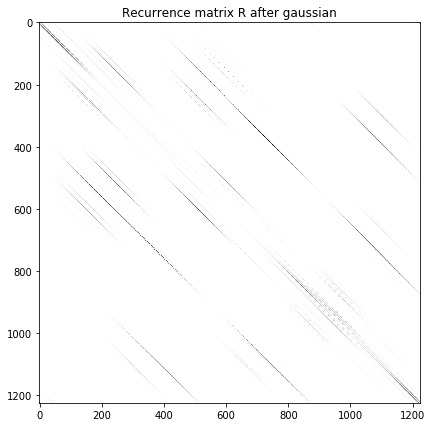

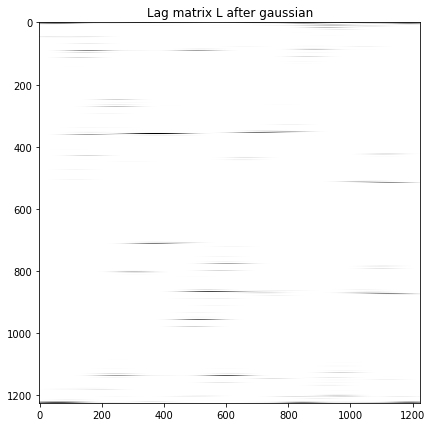

In [20]:
"""PLOTTING MATRICES after GAUSSIAN SMOOTHING"""
#Plot R matrix after Gaussian smoothing
P2 = librosa.segment.lag_to_recurrence(P, axis=-1)
plt.figure(figsize=(7, 7))
plt.title('Recurrence matrix R after gaussian')
plt.imshow(1-P2, cmap='gray')
plt.show()

#Plot Lag matrix after Gaussian smoothing
plt.figure(figsize=(7, 7))
plt.title('Lag matrix L after gaussian')
plt.imshow(1-P, cmap='gray')
plt.show()

Once $P$ has been obtained, we can construct vector $c$ which is the so called Novelty curve.

Vector $c = [c_1,...,c_{N-1}]$ is constructed from columns of matrix $P$: 

\begin{equation}
c_i = \mathrm{norm}(\mathrm{p}_{i+\mathrm{1}}, \mathrm{p}_i)
\end{equation}

where "norm" refers to the Euclidean norm.

In [21]:
#Novelty curve
c = np.linalg.norm(P[:,1:] - P[:,0:-1], axis=0) 
c_norm = (c - c.min()) / (c.max() - c.min()) #normalization of c

The novelty curve obtained is:

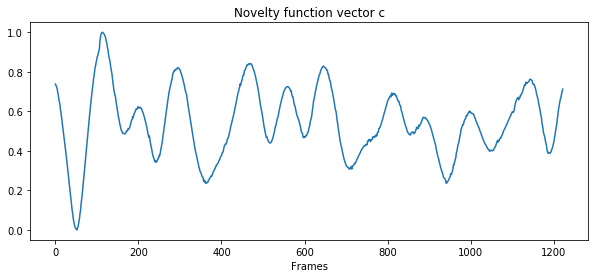

In [22]:
"""PLOTTING NOVELTY CURVE"""
#Plot novelty function with boundaries
frames = range(len(c_norm))
plt.figure(figsize=(10, 4))
plt.title('Novelty function vector c')
plt.xlabel('Frames')
plt.plot(frames, c_norm)
plt.show()

After obtaining the novelty curve $c$, we proceed with peak selection step. Positions of prominent peaks of are finally selected as segment boundaries. In Serrà's et al. paper the peak selection strategy is the following: a sample $c_i$ is considered to be a peak if it is above a certain threshold $\delta$ and, at the same time, corresponds to the global maximum of a window of length $\lambda$ centered at $c_i$.

To compensate for the offset introduced by delay coordinates in $\mathrm{\hat{x}}_i = [\mathrm{x}_i^\mathrm{T} \mathrm{x}_{i-\tau}^\mathrm{T}...\mathrm{x}_{i-(m-1)\tau}^\mathrm{T}]$, the exact boundary locations of the original time series $X$ are set to the locations of the selected peaks plus $w/2$.

Peak selection yields a set of boundary time stamps which,sorted in increasing order, are denoted by

\begin{equation}
\mathrm{b} = [b_1,...,b_M, b_{M+1},b_{M+2}]
\end{equation}

where $M$ is the total number of peaks found in $c$ and $b_{u+1}$, $u$ = 1,...,$M$, represents the location of the $u$-th peak. For notation convenience $b_1$ = 1 and $b_{M+2}$ = $N'$, denoting the start and end of the time series, respectively ($M$ boundaries in $c$ imply $M$ + 1 segments, which are represented by $M$ + 2 boundaries). Notice that, this way, boundaries $b_u$ and $b_{u+1}$ correspond to the beginning and end of the $u$-th segment.

Parameters:
* $\lambda$ = 6 seconds
* Threshold: $\delta$ = 0.05

In [23]:
#Peaks detection - sliding window
delta = 0.05 #threshold
lamda = round(6*sr/hop_length) #window length
peaks_position = signal.find_peaks(c_norm, height=delta, distance=lamda, width=round(0.5*sr/hop_length))[0] #array of peaks
peaks_values = signal.find_peaks(c_norm, height=delta, distance=lamda, width=round(0.5*sr/hop_length))[1]['peak_heights'] #array of peaks
b = peaks_position
#Adding elements 1 and N' to the begining and end of the arrray
if b[0] != 0:
    b = np.concatenate([[0], b]) #b: segment boundaries
if b[-1] != N_prima-1:
    b = np.concatenate([b, [N-1]])

We now can plot the novelty curve $c$ with the boundaries $b$ obtained after the peak picking step.

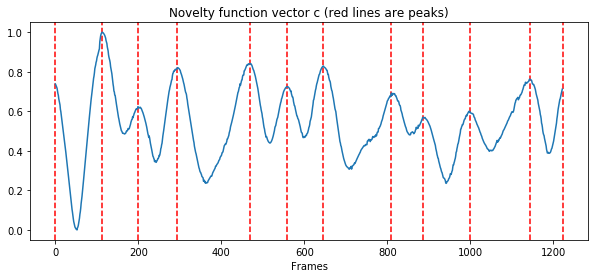

In [24]:
"""PLOTTING NOVELTY CURVE"""
#Plot novelty function with boundaries
frames = range(len(c_norm))
plt.figure(figsize=(10, 4))
plt.title('Novelty function vector c (red lines are peaks)')
plt.xlabel('Frames')
for i in range(len(b)):
    plt.axvline(b[i], color='r', linestyle='--') 
plt.plot(frames, c_norm)
plt.show()

## C. Segment Repetitions

Once we obtain estimates for segment boundaries we canemploy current time series similarity algorithms for computing segment-segment similarities. In our case we find it convenient to use the $Q_{max}$ measure. First,
it is a generic and configurable time series similarity measure. Second, it has been shown to perform well with PCP time series, outperforming other alignment-based measures in certain tasks. Third, it exploits the information
contained in the traces of a recurrence plot. Therefore, we can directly reuse $R$ as input for the $Q_{max}$ measure.

Given two segments $u$ and $v$, we express the slice of the Recurrence plot $R$ comparing $u$ and $v$ as

$$R^{(uv)} = \begin{bmatrix} 
R_{b_u,b_v}  & \dots & R_{b_u,b_{v+1}}\\ 
\vdots & \ddots & \vdots\\ 
R_{b_{u+1},b_v} & \dots & R_{b_{u+1},b_{v+1}}\\
\end{bmatrix}$$

where $b_u$ and $b_{u+1}$ are the limits of segment $v$. It is also defined the size of $R^{(uv)}$ as $l_u\mathrm{x}l_v$, with $l_u = b_{u+1}-b_u+1$ and $l_v = b_{v+1}-b_v+1$ being the lengths of segments $u$ and $v$ respectively. Then, the Cumulative matrix $Q^{(uv)}$ is built. 
$Q^{(uv)}$ has the same size as $R^{(uv)}$ and it is obtained by initialy settings it cells to 0 and recursively applying

\begin{equation}
Q^{(uv)}_{i,j} = \mathrm{max}\{ Q^{(uv)}_{i-1,j-1}, Q^{(uv)}_{i-2,j-1}, Q^{(uv)}_{i-1,j-2}  \} + R^{(uv)}_{i,j}.
\end{equation}

for $i = 1,...,l_u$ and $j = 1,...,l_v$, taking $Q^{(uv)}_{q,r}$ = 0 for $q,r <$ 1. 

This equation is the consequence of configuring the original $Q_{max}$ algorithm so that no penalties are applied for local disruptions or mismatches. This way, $Q_{max}$ measure, defined as $Q^{(uv)}_{max} = \mathrm{max}\{ Q^{(uv)}  \}$ turns into a global similarity measure considering all aligned sample matches from the beginning to the end of the time series being compared.

In [25]:
#Cumulative matrix: Q
Q = np.zeros_like(R)
for u in range(b.shape[0]-1):
    for v in range(b.shape[0]-1): 
        Q_uv = np.copy(R[b[u]:b[u+1], b[v]:b[v+1]])
        for i in range(1, Q_uv.shape[0]):
            for j in range(1, Q_uv.shape[1]):
                if i == 1 and j == 1:
                    Q_uv[i,j] += Q_uv[i-1,j-1]
                elif i == 1:
                    Q_uv[i,j] += max(Q_uv[i-1,j-1], Q_uv[i-1,j-2])
                elif j == 1:
                    Q_uv[i,j] += max(Q_uv[i-1,j-1], Q_uv[i-2,j-1])
                else:
                    Q_uv[i,j] += max(Q_uv[i-1,j-1], Q_uv[i-2,j-1], Q_uv[i-1,j-2])
                    
        Q[b[u]:b[u+1], b[v]:b[v+1]] = Q_uv

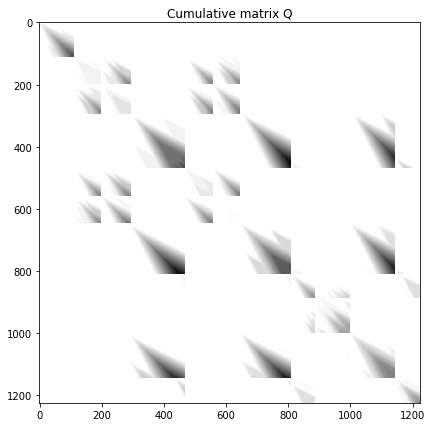

In [26]:
"""PLOTTING CUMULATIVE MATRIX"""
#Cumulative matrix plot
plt.figure(figsize=(7, 7))
plt.title('Cumulative matrix Q')
plt.imshow(1-Q, cmap='gray')
plt.show()

To obtain a segment similarity measure between 0 and 1 $Q^{(uv)}_{i,j}$ is normalizedby its maximum possible value (the length of the shortest segment), yielding

\begin{equation}
S_{u,v} = \frac{Q^{(uv)}_\mathrm{max}}{\mathrm{min} \{l_u,l_v\} }
\end{equation}

the similarity of segments $u$ and $v$. This operation is performed for all possible pairwise segment comparisons $u,v = 1,...,M+1$, obtaining a segment similarity matrix $S$. Notice that when $u = v$ the diagonal of $R^{(uv)}$ is completely filled with ones, and hence $S_{u,u} = 1$.

In [27]:
#Normalization of Q matrix: Segment similarity matrix S
num_segments = b.shape[0]-1
S = np.zeros((num_segments,num_segments))
for u in range(b.shape[0]-1):
    for v in range(b.shape[0]-1): 
        S[u,v] = np.max(Q[b[u]:b[u+1], b[v]:b[v+1]]) / min(b[u+1]-b[u], b[v+1]-b[v])

We plot the Segment Similarity matrix $S_{u,u}$: 

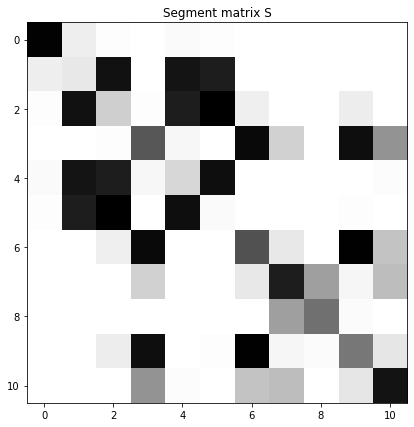

In [28]:
"""PLOTTING SEGMENT SIMILARITY MATRIX"""
#Plot Segment similarity matrix S
plt.figure(figsize=(7, 7))
plt.title('Segment matrix S')
plt.imshow(1-S, cmap='gray')
#for i in range(len(b)):
    #plt.axvline(b[i], color='r', linestyle='--') 
    #plt.axhline(b[i], color='r', linestyle='--') 
plt.show()

The next step in assessing segment repetitions is to decide which segments are similar enough so that they can be assigned to the same structural label. To do so we simply threshold the similarity matrix $S$ by $\phi=\mu(S)+\sigma(S)$ where $\mu(S)$ and $\sigma(S)$ are the mean and standard deviation of all the values in $S$, respectively. The definition of threshold $\phi$ is rather arbitrary, but with the intention of discarding segment similarities that are below or around the average segment similarity of the time series.

The simple threshold operation above does not enforce transitivity, i.e., if a segment 1 is close (or similar) to a segment 2, and segment 2 close to a segment 3, it does not guarantee that segment 1 is close to segment 3. To enforce transitivity we recursively multiply $S$ by itself (matrix multiplication) and threshold the resulting matrix by 1 (i.e., we set its entries to 1 if they are above 1 and 0 otherwise) until no changes are produced in $S$. We denote this final result as $\hat{S}$. The final assignment of labels is then straightforward: the label A is given to all segments that correspond to the 1-entries of the first row of $\hat{S}$, the label B to all segments that correspond to the 1-entries of the next row that differs from the previously considered ones, and so forth until all rows of $\hat{S}$ have been processed.

In [29]:
#Transitive Binary Similarity Matrix: S_hat
S_hat = S > S.mean() + S.std() 
S_hat_norm = np.matmul(S_hat, S_hat)
while (S_hat_norm < S_hat).all():
    S_hat = S_hat_norm
    S_hat_norm = np.matmul(S_hat, S_hat)
    S_hat_norm = S_hat_norm >= 1

We plot the Transitive binary similarity matrix $\hat{S}$:

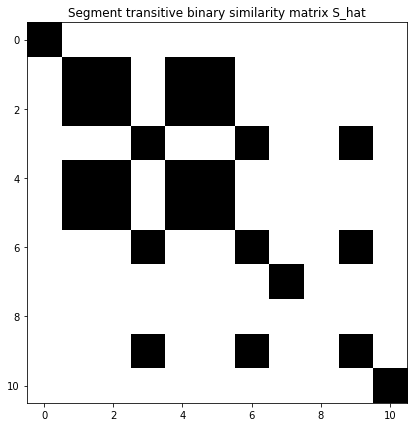

In [30]:
"""PLOTTING TRANSITIVE BINARY SIMILARITY MATRIX"""
#Plot transitive binary similarity matrix S_hat
plt.figure(figsize=(7, 7))
plt.title('Segment transitive binary similarity matrix S_hat')
plt.imshow(1-S_hat_norm, cmap='gray')
plt.show()  

If we want to plot the matrices with the ground truth, we just have to extract the labels of the song from its file. In the casse of SALAMI 2.0 database, the selected labels in this case have been extracted from functions.txt file with this functions:

In [31]:
#Image vs ground truth
from os import listdir, walk, getcwd, sep
import numpy as np

def ReadNumbersFromLine(linea):
    linea = ''.join(i for i in linea if not i.isalpha())
    sinbarras = ''.join(j for j in linea if not j == '/')
    sinespacios = ''.join(n for n in sinbarras if not n.isspace())
    sinnombres =''.join(k for k in sinespacios if not k == '_')
    numeroslinea =''.join(p for p in sinnombres if not p == '-')
    n = ''.join(m for m in numeroslinea if not m == "'")
    numeros = ''.join(p for p in n if not p == '&')
    return numeros

def ReadDataFromtxt(directorio, archivo):
    numbers = []
    for path in listdir(directorio):
        file = open(directorio + archivo, "r")
    for line in file:
        numbers.append(ReadNumbersFromLine(line))
    file.close()
    return numbers 

We now can plot the matrices with its labels (in this case we only plot the Segment similarity matrix $S$):

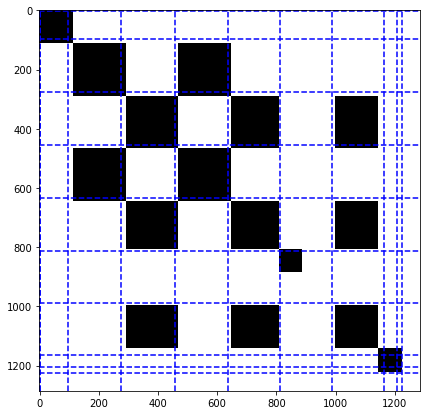

In [32]:
"""PLOTTING S with LABELS"""
S_frames = np.zeros_like(Q)
for u in range(b.shape[0]-1):
    for v in range(b.shape[0]-1): 
        S_frames[b[u]:b[u+1], b[v]:b[v+1]] = S_hat_norm[u,v]


label_path = "/home/carlos/Documentos/"
file = "/textfile1_functions.txt"
labels_array = np.asarray(ReadDataFromtxt(label_path, file))
array = labels_array.astype(np.float)

plt.figure(figsize=(7, 7))
plt.imshow(1-S_frames, cmap='gray')
for i in range(len(array)):
    plt.axvline(array[i]*sr/hop_length, color='b', linestyle='--')
    plt.axhline(array[i]*sr/hop_length, color='b', linestyle='--')
plt.show() 

The novelty curve $c$ with the true labels can also be plotted:

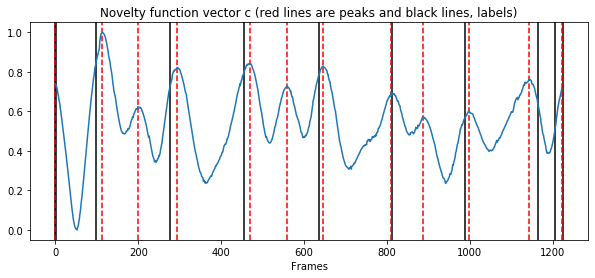

In [35]:
"""PLOTTING NOVELTY CURVE"""
#Plot novelty function with boundaries
frames = range(len(c_norm))
plt.figure(figsize=(10, 4))
plt.title('Novelty function vector c (red lines are peaks and black lines, labels)')
plt.xlabel('Frames')
for i in range(len(array)):
    plt.axvline(array[i]*sr/hop_length, color='black', linestyle='-')
for i in range(len(b)):
    plt.axvline(b[i], color='r', linestyle='--') 
plt.plot(frames, c_norm)
plt.show()